In [4]:
import numpy as np
import matplotlib.pyplot as plt
from discretize_tools import rouwenhorst, grow_grid
from scipy.optimize import root
from linear import linint
import time
import math as m

In [5]:
class LifeCycle:
    '''
    This is the class of the life-cycle model
    '''
    
    def __init__(self,
                γ = 0.5, β = 0.98, r = 0.04, w = 1.0, J = 80, JR = 45,
                NP = 2, NS = 7, NA = 201, ν = 0.335, σθ = 0.242, σϵ = 0.022,
                ρ = 0.985, al = 0, au = 200, agrow = 0.05, θprob = [0.5,0.5],
                ψ = np.array([1.00000, 0.99923, 0.99914, 0.99914, 0.99912, \
                0.99906, 0.99908, 0.99906, 0.99907, 0.99901, \
                0.99899, 0.99896, 0.99893, 0.99890, 0.99887, \
                0.99886, 0.99878, 0.99871, 0.99862, 0.99853, \
                0.99841, 0.99835, 0.99819, 0.99801, 0.99785, \
                0.99757, 0.99735, 0.99701, 0.99676, 0.99650, \
                0.99614, 0.99581, 0.99555, 0.99503, 0.99471, \
                0.99435, 0.99393, 0.99343, 0.99294, 0.99237, \
                0.99190, 0.99137, 0.99085, 0.99000, 0.98871, \
                0.98871, 0.98721, 0.98612, 0.98462, 0.98376, \
                0.98226, 0.98062, 0.97908, 0.97682, 0.97514, \
                0.97250, 0.96925, 0.96710, 0.96330, 0.95965, \
                0.95619, 0.95115, 0.94677, 0.93987, 0.93445, \
                0.92717, 0.91872, 0.91006, 0.90036, 0.88744, \
                0.87539, 0.85936, 0.84996, 0.82889, 0.81469, \
                0.79705, 0.78081, 0.76174, 0.74195, 0.72155, \
                0.00000]),
                eff = np.array([1.0000, 1.0719, 1.1438, 1.2158, 1.2842, 1.3527, \
                1.4212, 1.4897, 1.5582, 1.6267, 1.6952, 1.7217, \
                1.7438, 1.7748, 1.8014, 1.8279, 1.8545, 1.8810, \
                1.9075, 1.9341, 1.9606, 1.9623, 1.9640, 1.9658, \
                1.9675, 1.9692, 1.9709, 1.9726, 1.9743, 1.9760, \
                1.9777, 1.9700, 1.9623, 1.9546, 1.9469, 1.9392, \
                1.9315, 1.9238, 1.9161, 1.9084, 1.9007, 1.8354, \
                1.7701, 1.7048])):
        self.γ, self.β, self.ν, self.r, self.w = γ, β, ν, r, w
        self.J,self.JR,self.NA,self.NP,self.NS = J, JR, NA, NP, NS
        self.egam = 1- 1/γ
        
        # persistent shock grid
        self.θ = np.exp(np.array([-1,1])*σθ**0.5)
        self.θprob = θprob
        
        # stochastic shock grid
        self.η, self.π = rouwenhorst(ρ, σϵ**0.5, NS)
        self.η = np.exp(self.η)
        self.middle = int((NS + 1)/2) - 1
        # self.middle is the index of the 0 shock in the grid
        
        # asset grid
        self.a = grow_grid(al , au, agrow, NA)
        self.al, self.au, self.agrow = al, au, agrow
        
        # surving probability and labor efficiency and pensions
        self.ψ = ψ
        self.eff = np.concatenate((eff, np.zeros(J - JR +1)))
        self.pen = np.concatenate(( np.zeros(JR - 1), np.ones(J - JR + 1)*(0.5*w*eff.sum()/(JR - 1) *0.33)))
        
        # derive policy function from the 'get_policy' function
        self.aplus, self.c, self.l, self.V = self.get_policy()
        
        # get distribution of agents
        self.ϕ = self.distribution()
        
        self.c_coh, self.y_coh, self.l_coh, self.h_coh, self.a_coh, self.v_coh, self.cv_c, \
        self.cv_y, self.cv_l, self.cv_h, self.corr_hl = self.aggregation()
        
        
        
    def get_policy(self):
        global RHS, EV, c, l, V
        aplus = np.zeros((self.J,self.NA,self.NP,self.NS))
        c = aplus.copy()
        l = aplus.copy()
        V = aplus.copy()
        RHS = aplus.copy()
        EV = aplus.copy()
        
        
        def foc(ap):
        
            wage = self.w*self.eff[j]*self.θ[p]*self.η[s]
            
            avail = (1+self.r)*self.a[i] + self.pen[j]

            if j < self.JR-1:
                laux = min(max(self.ν + (1-self.ν)*(ap - avail)/wage , 0), 1-1e-10)
            else:
                laux = 0

            caux = max(avail + wage*laux - ap, 1e-10)

            LHS = ((self.ν*(caux**self.ν*(1-laux)**(1-self.ν))**(self.egam))/caux)**(-self.γ)
            ## Note: transform to **-γ to keep consistence with RHS


            ap = max(ap, self.al)
            
            il, ir, φ1 = linint(ap, self.al, self.au, self.agrow, self.NA)

            RHSaux = φ1 * RHS[j+1, il, p, s] + (1-φ1) * RHS[j+1, ir, p, s]

            foc = LHS - RHSaux

            return foc
        
        # get decisions in the last period
        
        for i in range(self.NA): # along the asset grid
            aplus[-1,i,:,:] = 0 # the asset of J+1 period is 0
            c[-1,i,:,:] = (1 + self.r) * self.a[i] + self.pen[-1]
            l[-1,i,:,:] = 0
            V[-1,i,:,:] = self.VF(0, c[-1,i,0,0], l[-1,i,0,0], self.J-1, 0,0)
            
            ## up to this stage, we have already known the policy rules for the last period (J-1)
            ## so from the previous period perspevtive (J-2), we can calculate the expected value
            ## of the last period(J-1) as we already know all the value of V[J-1,:,:,:]
            
        self.interpolate(self.J-1)
        
        
        for j in range(self.J-2,-1,-1):
            
            if j >= self.JR - 1: 
            
            ## after retire, eff[j] = 0 , do not need to consider the heterogeneity of θ, η.
            ## all the income of the retirement period is a*(1+r) + pen as w*h = 0
            
                pmax = 1 ## just use the θ[0] to calculate, then copy the result to θ[1]
                smax = 1 ## same as above
            else:
                pmax = self.NP ## in the working period, we need to calculate all the state of θ seperately
                smax = self.NS ## same as above
                
            for i in range(self.NA):
                if j >= self.JR - 1 and i == 0 and self.pen[j] < 1e-10:
                    ## this step is to calculate the agents who are in the retirement period and has no asset
                    ## left and there is no pension result. In such situation, we cannnot get the policy function
                    ## numerically. Instead, we set them manualy.
                    
                    aplus[j,i,:,:] = 0 ## tomorrow's asset is obviously zero
                    c[j,i,:,:] = 0 ## also, consumption is obviously zero as there is no income at all
                    l[j,i,:,:] = 0 ## same as above
                    V[j,i,:,:] = self.VF(0, 0, 0, j, 0, 0)
                    
                    continue

                for p in range(pmax):
                    for s in range(smax):                      
                        ap = root(foc, x0 = aplus[j+1,i,p,s]).x[0]
                        ## ap stands for aplus, we cannot use aplus as variable names twice

                        if ap < 0:
                            ap = 0
                            
                        wage = self.w * self.eff[j] * self.θ[p] * self.η[s]
                        avail = (1+self.r)*self.a[i] + self.pen[j] - ap
                        if j < self.JR-1:
                            laux = min(max(self.ν - (1-self.ν)*avail/wage , 0), 1-1e-10)
                        else:
                            laux = 0
                        caux = max( avail + wage*laux , 1e-10)

                        aplus[j,i,p,s] = ap
                        c[j,i,p,s] = caux
                        l[j,i,p,s] = laux
                        V[j,i,p,s] = self.VF(ap, caux, laux, j, p, s)
                        
                        
                if j >= self.JR - 1:
                    aplus[j,i,:,:] = aplus[j,i,0,0]
                    c[j,i,:,:] = c[j,i,0,0]
                    l[j,i,:,:] = l[j,i,0,0]
                    V[j,i,:,:] = V[j,i,0,0]
                    
            self.interpolate(j)
        
        return aplus, c, l, V
        
            
    def interpolate(self,j):
        global RHS, EV
        for i in range(self.NA):
            for p in range(self.NP):
                for s in range(self.NS):
                    # calculate the RHS of the first order condition

                    RHS[j,i,p,s] = 0.0
                    EV[j,i,p,s] = 0.0

                    caux = np.maximum(c[j,i,p,:], 1e-10)
                    laux = np.maximum(l[j,i,p,:], 1e-10)
                    
                    margu = (self.ν*(caux**self.ν*(1-laux)**(1-self.ν))**(self.egam))/caux

                    RHS[j,i,p,s] = (self.β * self.ψ[j] * (1+self.r) * (self.π[s,:] @ margu))**(-self.γ)
                    EV[j,i,p,s] = (self.egam* (self.π[s,:] @ V[j,i,p,:]))**(1/self.egam)
            
    def VF(self, ap, cons, leis, j, p, s): ## value function calculate (for each aplus, j,p,s are specified)
        
        cons = max(cons, 1e-10)
        leis = min( max(leis, 0), 1 - 1e-10)
        
        ir, il, φ0 = linint(ap, self.al, self.au, self.agrow, self.NA)
        
        vf = 0
        
        # tomorrow's utility, if j = J-1 (the last period because of the pythonic index), tomorrow's utility is 0
        if j < self.J-1:
            vf = max( φ0*EV[j+1,il,p,s] + (1-φ0)*EV[j+1,ir,p,s], 1e-10 )**self.egam/self.egam
            # self.egam/self.egam because we transform the EV matrix
        
        vf = (cons**self.ν*(1-leis)**(1-self.ν))**self.egam/self.egam + self.β*self.ψ[j+1]*vf
        
        return vf
    
    
    def distribution(self):
        
        ϕ = np.zeros((self.J, self.NA, self.NP, self.NS))
        
        for p in range(self.NP):
            ϕ[0,0,p,self.middle] = self.θprob[p]
        ## calcualte frist period's distribution (asset is 0, η = exp(0))
        
        for j in range(1,self.J):
            for i in range(self.NA):
                for p in range(self.NP):
                    for s in range(self.NS):
                        il, ir, φ2 = linint(self.aplus[j-1,i,p,s], self.al, self.au, self.agrow, self.NA)             
                        il = min(il, self.NA)
                        ir = min(ir, self.NA)
                        φ2 = min(φ2, 1)
                        
                        ϕ[j, il, p, :] += self.π[s,:] * φ2* ϕ[j-1,i,p,s]
                        ϕ[j, ir, p, :] += self.π[s,:] * (1-φ2) * ϕ[j-1,i,p,s]
        return ϕ
    
    def aggregation(self):
        c_coh = np.zeros(self.J)
        y_coh = np.zeros(self.J)
        l_coh = np.zeros(self.J)
        h_coh = np.zeros(self.J)
        a_coh = np.zeros(self.J)
        v_coh = np.zeros(self.J)
        
        
        cv_c = np.zeros(self.J)
        cv_y = np.zeros(self.J)
        cv_l = np.zeros(self.J)
        cv_h = np.zeros(self.J)
        corr_hl = np.zeros(self.J)



        for j in range(self.J):
            for i in range(self.NA):
                for p in range(self.NP):
                    for s in range(self.NS):
                        c_coh[j] += self.c[j,i,p,s]*self.ϕ[j,i,p,s]
                        y_coh[j] += self.eff[j]*self.θ[p]*self.η[s]*self.l[j,i,p,s]*self.ϕ[j,i,p,s]
                        l_coh[j] += self.l[j,i,p,s]*self.ϕ[j,i,p,s]
                        h_coh[j] += self.eff[j]*self.θ[p]*self.η[s]*self.ϕ[j,i,p,s]
                        a_coh[j] += self.a[i]*self.ϕ[j,i,p,s]
                        v_coh[j] += self.V[j,i,p,s]*self.ϕ[j,i,p,s]

        # calculate cohort specific coefficients of variation
        for j in range(self.J):
            for i in range(self.NA):
                for p in range(self.NP):
                    for s in range(self.NS):
                        cv_c[j] += self.c[j,i,p,s]**2*self.ϕ[j,i,p,s]
                        cv_y[j] += (self.eff[j]*self.θ[p]*self.η[s]*self.l[j,i,p,s])**2*self.ϕ[j,i,p,s]
                        cv_l[j] += self.l[j,i,p,s]**2*self.ϕ[j,i,p,s]
                        cv_h[j] += (self.eff[j]*self.θ[p]*self.η[s])**2*self.ϕ[j,i,p,s]
                        corr_hl[j] += self.eff[j]*self.θ[p]*self.η[s]*self.l[j,i,p,s]*self.ϕ[j,i,p,s]
        
        corr_hl = (corr_hl - h_coh*l_coh)/np.maximum(((cv_h - h_coh**2)**0.5*(cv_l - l_coh**2)**0.5), 1e-10)
        
        cv_c = (cv_c - c_coh**2)**0.5/c_coh
        cv_y = (cv_y - y_coh**2)**0.5/np.maximum(y_coh, 1e-10)
        cv_l = (cv_l - l_coh**2)**0.5/np.maximum(l_coh, 1e-10)
        cv_h = (cv_h - h_coh**2)**0.5/np.maximum(h_coh, 1e-10)
        
        return c_coh, y_coh, l_coh, h_coh, a_coh, v_coh, cv_c, cv_y, cv_l, cv_h, corr_hl


In [6]:
tstart = time.time()

model = LifeCycle()

tend = time.time()


time_taken = tend - tstart
hours = m.floor(time_taken/3600)
mins = m.floor((time_taken - hours*3600)/60)
secs = time_taken - hours*3600 - mins*60
print('Time Used: {}h{}m{}s'.format(hours, mins, int(secs)))  

Time Used: 0h0m37.77602481842041s


(0.0, 1.8)

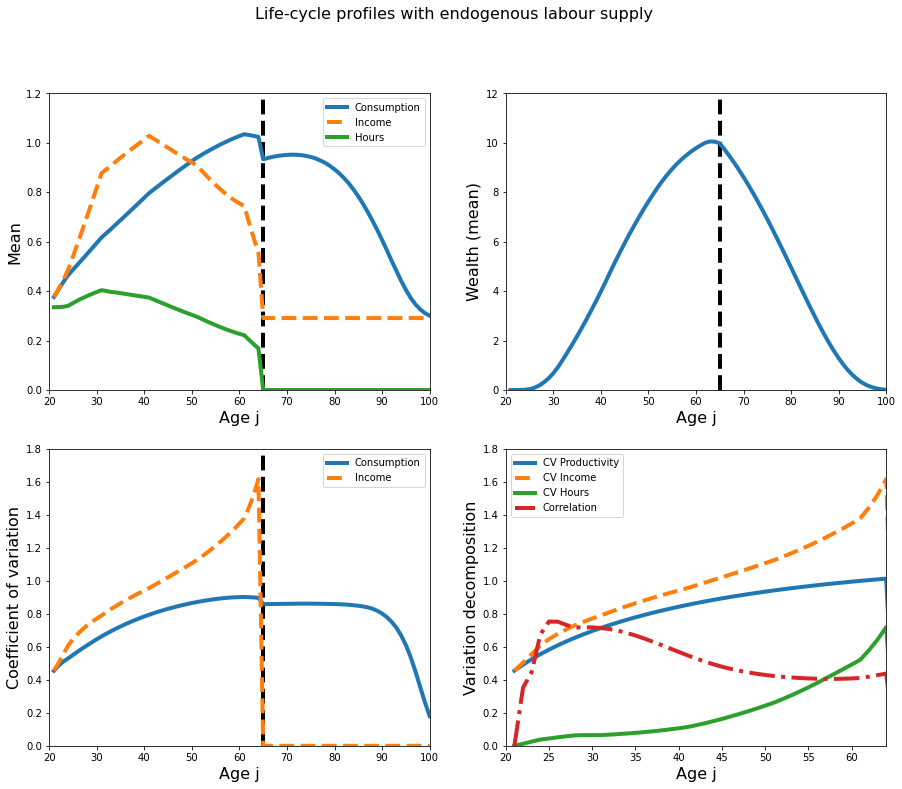

In [7]:
fig, ax = plt.subplots(2,2, figsize = (15,12))
fig.suptitle('Life-cycle profiles with endogenous labour supply',fontsize = '16')
plt.rcParams['lines.linewidth'] = '4'
age = np.arange(model.J) + 21

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Age j',fontsize = '16')
        if not (i==1 and j==1):
            ax[i,j].axvline(x = 65, c = 'k', linestyle = '--')
            ax[i,j].set_xlim(20,100)
        

ax[0,0].plot(age, model.c_coh,label = 'Consumption' )
ax[0,0].plot(age, model.y_coh + model.pen,label = 'Income',linestyle = '--')
ax[0,0].plot(age, model.l_coh, label = 'Hours')
ax[0,0].legend()
ax[0,0].set_ylabel('Mean',fontsize = '16')
ax[0,0].set_ylim(0,1.2)

ax[0,1].plot(age, model.a_coh)
ax[0,1].set_ylabel('Wealth (mean)',fontsize = '16')
ax[0,1].set_ylim(0,12)


ax[1,0].plot(age, model.cv_c, label = 'Consumption')
ax[1,0].plot(age, model.cv_y, label = 'Income',linestyle = '--')
ax[1,0].legend()
ax[1,0].set_ylabel('Coefficient of variation',fontsize = '16')
ax[1,0].set_ylim(0,1.8)

ax[1,1].plot(age, model.cv_h, label = 'CV Productivity')
ax[1,1].plot(age, model.cv_y, label = 'CV Income',linestyle = '--')
ax[1,1].plot(age, model.cv_l, label = 'CV Hours')
ax[1,1].plot(age, model.corr_hl, label = 'Correlation',linestyle = '-.')
ax[1,1].legend()
ax[1,1].set_xlim(20,64)
ax[1,1].set_ylabel('Variation decomposition',fontsize = '16')
ax[1,1].set_ylim(0,1.8)
